# LSTM for Time Series Prediction in PyTorch

> Run:    
> Personally, running it in a dockerized, gpu/cuda-enabled pytorch/notebook environment (cf. [github/gpu-jupyter](https://github.com/iot-salzburg/gpu-jupyter))

- *Updated from this source [article](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)*, with famous "Airline" dataset  
- *What was **added** :*  
    - clarifies steps / order making data stationary / normalization (a common mistake/lack of in a lot of online ressources)
    - Make data stationary (first order diff). Not mandatory with a lstm but very common, recommended and usually improves performance
    - More structure / pipelined : transform functions (normalize / inverse diff via cumsum etc.), steps / notes on arrays shape etc.   
    - Normalization (minmax)
    - Input size (loopback) directly set to 4 (vs. 1, then 4)
    - benchmark models accuracy with and without statio. + scaling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Load data

In [2]:
df = pd.read_csv('data/airline-passengers.csv')
df.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


Drop index (year-month) and keep dependent variable as a Series of float

In [3]:
#for a 2d array, would be like below, but for easier transformations etc, we chose 1D array format
ts2 = df[["Passengers"]].values.astype('float32')
ts2[0:3]

array([[112.],
       [118.],
       [132.]], dtype=float32)

In [4]:
ts2.shape

(144, 1)

In [5]:
# for 1d array
ts = df["Passengers"].values.astype('float32')
ts[0:3]

array([112., 118., 132.], dtype=float32)

In [6]:
ts.shape

(144,)

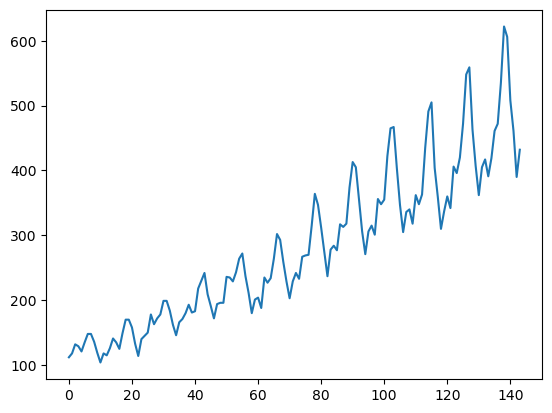

In [7]:
plt.plot(ts)

### Steps overview. Order matters

- 1. check if stationary / make stationary (e.g first order or other method). Ok to be before train/test split
- 2. train - test split, **before** applying scaling (normalization), to avoid information leakage
- 3. apply normalization, minmax is recommended for lstm / time series prediction. Fit on train test, transform train / test sets
- 4. define how you want the nn to predict : define the look back windows / input width = how much data allowed to look at when make prediction
- 5. create dataset : loop back + tensor shape to be compatible with Pytorch / LSTM
- 6. create model as a class, or function
- 7. train model & eval : loss function MSE (because regression), minimized by Adam optimizer.

### Train test split

In [8]:
# input/output 1D array time series (ts)
train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size
train, test = ts[:train_size], ts[train_size:]

### Preprocessing / post-processing (make/revert stationary, normalize)

From plot, data clearly strong, linear trend, not stationary at all -> we make data stationary, using built-in diff method in numpy (first order diff). We will also make sure to save first value to be able to revert the diff.  

**Preprocessing / post-processing functions:**

Note on input/output data shape 
We're using 1D array with 1 feature as input/output of our transformations steps for convenience/consistency  
When needed, we reshape data e.g. minmax scaler from sklearn need 2D array as input. But we keep output as 1D.  
Later on (LSTM prep), this will change (2D/3D)

In [9]:
# Dave first value ("offset") for later easy un-differenciating with cumsum + offset
def get_offset(time_series: np.array) -> float:
    """
    Save offset, for later reverse differenciating
    Notes i/o:
    Input 1d array time series
    """
    return time_series[0]

# Differentiate (here first order)
def make_stationary(time_series: np.array) -> np.array:
    """
    Make Time Series stationary (remove trend), using first order difference
    Not mandatory with a lstm but very common, recommended and usually improves performance
    Notes i/o:
    - 1d array time series
    - Apply on whole dataset, or after train-test, should not matter that much cause we're only using previous value.
    - source : https://datascience.stackexchange.com/questions/96876/applying-differencing-on-a-time-series-before-or-after-train-and-test-split
    
    """
    ts_stationary = np.diff(time_series)
    return ts_stationary

# func to revert differentiating; with input "offset"
def revert_differenciating(time_series: np.array, offset: float) -> np.array:
    """Revert first order differenciating, using saved offset"""
    ts_undiff = np.cumsum(time_series)
    ts_undiff = ts_undiff + offset
    # add back original first value
    ts_undiff = np.insert(ts_undiff, 0, offset)
    return ts_undiff

# scale data, recommended for LSTM is minmax,
# but for time series if strong trend (up or down) might not be the best
# because future data max/low might being out of bound ; domain knowledge can help too.
def normalize(time_series: np.array) -> np.array:
    """
    Apply min max scaler, fit on train
    Reminder : fit on train set only, then transform both train and test
    Input is 1D array
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    # test.reshape(-1,1) : input array must be reshape prior norm.
    scaler_min_max = scaler.fit(time_series.reshape(-1,1))
    ts_normalized = scaler_min_max.transform(time_series.reshape(-1,1))
    # back to 1D
    ts_normalized_1D = ts_normalized.flatten()
    return scaler_min_max, ts_normalized_1D

def inverse_normalize(scaler, time_series: np.array) -> np.array:
    """Reverse min max scaler. Input is 1D array"""
    time_series_inverse = scaler.inverse_transform(time_series.reshape(-1, 1))
    time_series_inverse_1D = time_series_inverse.flatten()
    return time_series_inverse_1D

def to_2d(array: np.array) -> np.array:
    """Convenience function for code transparency when we convert 1D array to 2D"""
    array2 = array.reshape(-1,1)
    return array2


### Optional : test & viz for transfo. (station., scaling) - inverse transform  / data distribution

#### Make stationary / revert differenciating

In [10]:
offset = get_offset(ts)
offset

112.0

In [11]:
ts

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [12]:
ts.shape

(144,)

In [13]:
ts_stationary = make_stationary(ts)
ts_stationary[0:10]

array([  6.,  14.,  -3.,  -8.,  14.,  13.,   0., -12., -17., -15.],
      dtype=float32)

In [14]:
ts_stationary.shape

(143,)

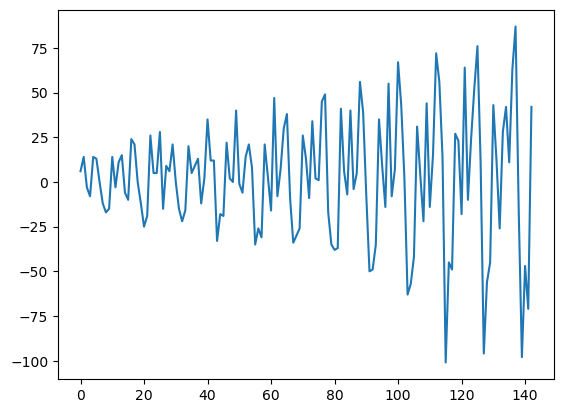

In [15]:
plt.plot(ts_stationary)

In [16]:
ts_undiff = revert_differenciating(ts_stationary, offset)
ts_undiff[0:10]

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119.],
      dtype=float32)

In [17]:
ts_undiff.shape

(144,)

#### Normalize / inverse normalize

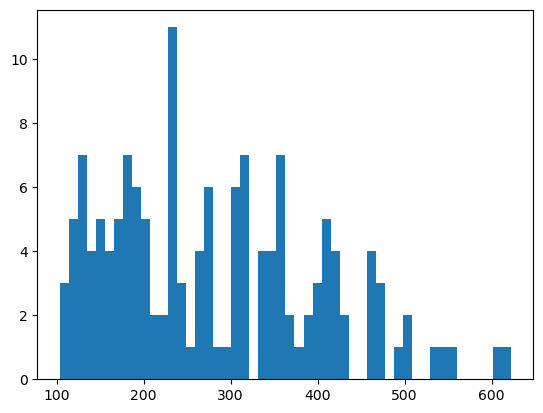

In [18]:
# initial shape - just check data distribution shape (gaussian or not)
hist = plt.hist(ts, bins=50)

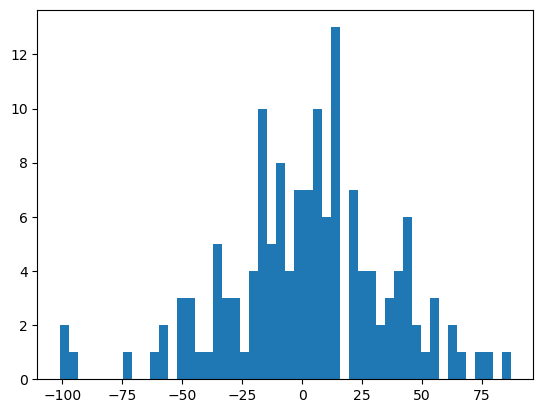

In [19]:
_ = plt.hist(ts_stationary, bins=50)

Data **not** made stationary prior :

In [20]:
scaler, ts_normalized = normalize(ts)
print(ts_normalized[0:10])
print(ts_normalized.ndim)

[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
1


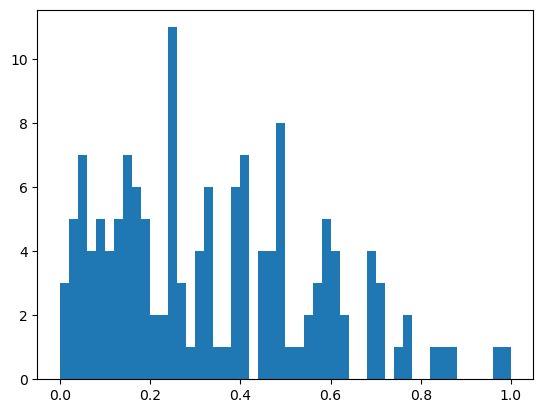

In [21]:
_ = plt.hist(ts_normalized, bins=50)

In [22]:
time_series_inverse = inverse_normalize(scaler, ts_normalized)
print(time_series_inverse[0:10])
print(time_series_inverse.ndim)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119.]
1


Data made **stationary** prior :

In [23]:
scaler, ts_normalized2 = normalize(ts_stationary)
print(ts_normalized2[0:10])
print(ts_normalized2.ndim)

[0.5691489  0.6117021  0.52127653 0.49468082 0.6117021  0.60638297
 0.537234   0.47340423 0.4468085  0.45744678]
1


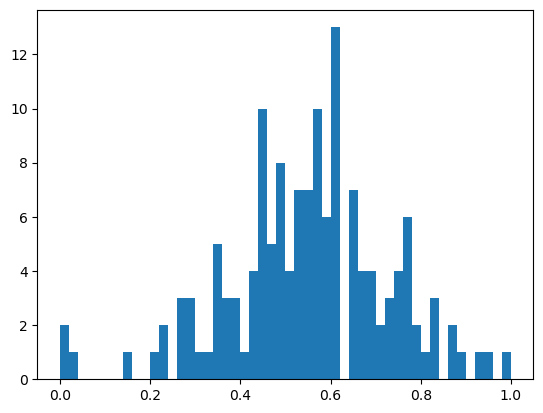

In [24]:
_ = plt.hist(ts_normalized2, bins=50)

## LTSM Pytorch modeling

### Reshape dataset

- Here, Univariate : one feature (number of passengers). We could have added / built others from date.
- Several ways to prepare dataset for lstm/time series : 
    - e.g. multiple inputs -> multiple outputs vs. multiple inputs -> single output
    - hopping/overlapping windows, step size of the sliding window... (we're using 1 below)
- Convert a time series into a tensor of dimensions (window sample, time steps, features)  
- Below : multiple (4) inputs -> multiple outputs/targets (4)

In [25]:
def create_dataset(dataset, loopback):
    """
    Transform a time series into a prediction dataset
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    Output: Pytorch 3D tensors
    """
    X, y = [], []
    for i in range(len(dataset)-loopback):
        feature = dataset[i:i+loopback]
        target = dataset[i+1:i+loopback+1]
        X.append(feature)
        y.append(target)
    # Optional but prevent warning performance message :
    # Convert the lists to numpy arrays and then to Pytorch tensors.
    X = torch.tensor(np.array(X))
    y = torch.tensor(np.array(y))
    return X, y

#### Optional : Test create dataset / reshape array

In [26]:
# input must be a 2D array
train, test = to_2d(train), to_2d(test)
train[0:3]

array([[112.],
       [118.],
       [132.]], dtype=float32)

In [27]:
train.shape

(96, 1)

In [28]:
train.ndim

2

In [29]:
loopback = 4
dataset_X_train, dataset_y_train = create_dataset(train, loopback)
dataset_X_test, dataset_y_test = create_dataset(test, loopback)

In [30]:
train[0:6]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.]], dtype=float32)

In [31]:
dataset_X_train[0:2]

tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]]])

In [32]:
dataset_y_train[0:2]

tensor([[[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]]])

In [33]:
print(dataset_X_train.shape, dataset_y_train.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])


In [34]:
print(dataset_X_test.shape, dataset_y_test.shape)

torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


### Create LSTM model

Refer to [source](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

In [35]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Train Model, Part 1 : vanilla, no prior ts made stationarity and scaling

- regression problem -> mse (or rmse) as loss function
- batch for training provided by DataLoader (torch.utils.data)
- model performance is evaluated once per 100 epochs

In [36]:
# create dataset with correct shape

lookback = 4
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

In [37]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.3603, test RMSE 425.6137
Epoch 100: train RMSE 177.5788, test RMSE 374.4461
Epoch 200: train RMSE 140.1098, test RMSE 333.4092
Epoch 300: train RMSE 109.9061, test RMSE 297.3384
Epoch 400: train RMSE 85.7598, test RMSE 264.3087
Epoch 500: train RMSE 65.1196, test RMSE 231.3552
Epoch 600: train RMSE 51.2115, test RMSE 204.2940
Epoch 700: train RMSE 41.2877, test RMSE 180.6524
Epoch 800: train RMSE 34.3589, test RMSE 159.8569
Epoch 900: train RMSE 29.5694, test RMSE 141.9774
Epoch 1000: train RMSE 26.4370, test RMSE 127.3008
Epoch 1100: train RMSE 24.0727, test RMSE 115.2129
Epoch 1200: train RMSE 22.6640, test RMSE 105.7501
Epoch 1300: train RMSE 21.9178, test RMSE 98.8958
Epoch 1400: train RMSE 21.5942, test RMSE 92.0856
Epoch 1500: train RMSE 20.4394, test RMSE 88.5743
Epoch 1600: train RMSE 19.9554, test RMSE 84.5562
Epoch 1700: train RMSE 20.3427, test RMSE 81.8090
Epoch 1800: train RMSE 19.3340, test RMSE 78.9184
Epoch 1900: train RMSE 19.0551, test RMSE 77.

#### Plot the output

Take the model’s output as y_pred but extract only the data from the last time step as y_pred[:, -1, :]. This is what is plotted on the chart.

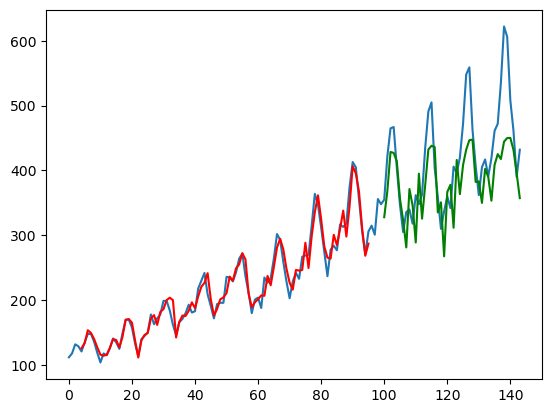

In [38]:
timeseries = ts2 # 2d array input

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### Train Model, Part 2 : with prior data made stationarity and normalization (minmax) applied